# Grad-CAM for tumor detection

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

In [2]:
from tensorflow.keras.models import load_model

model = load_model("models/Tumor_dtc_model.h5", compile=False)

In [69]:
import cv2

image_path = "brain_tumor_dataset/yes/Y100.jpg"
img_size = (299, 299)
last_conv_layer_name = "dense_1"

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       2

In [79]:
target_layer = model.layers[-8]
target_layer

In [80]:
grad_model = tf.keras.models.Model(
    [model.inputs], [target_layer.output, model.output]
)

In [81]:
def preprocess_image(img):
    img = img.astype('float32')
    img /= 255.0
    return np.expand_dims(img, axis=0)

In [88]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))
preprocessed_image = preprocess_image(image)
preprocessed_image.shape

(1, 256, 256, 3)

In [105]:
def grad_cam(img_array, model, layer_name):
    inputs = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        predicted_class = tf.argmax(predictions[0])  # Get the predicted class index

        loss = predictions[:, predicted_class]
        grads = tape.gradient(loss, conv_outputs)

    gradients = grads[0]
    weights = tf.reduce_mean(gradients, axis=(0, 1))

    # Reshape the weights to match the spatial dimensions of conv_outputs
    weights = tf.reshape(weights, (1, 1, 1, -1))

    # Multiply the weights with conv_outputs to get the heatmap
    heatmap = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert the heatmap to a three-channel image for applying the color map
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2BGR)

    img_array = (img_array[0] * 255.0).astype(np.uint8)  # Scale image array to [0, 255]

    # Resize the image to match the heatmap dimensions
    img_array = cv2.resize(img_array, (heatmap.shape[1], heatmap.shape[0]))

    superimposed_img = cv2.addWeighted(img_array, 0.6, heatmap, 0.4, 0)
    return superimposed_img


In [ ]:
gradcam_image = grad_cam(preprocessed_image, model, target_layer.name)

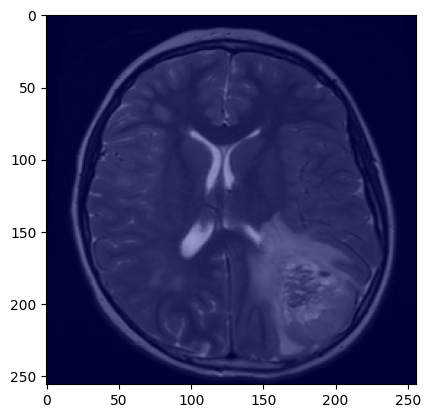

In [73]:
plt.imshow(gradcam_image);